# Part I: Optimal span for LOESS

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skmisc.loess import loess
from sklearn.model_selection import LeaveOneOut

In [35]:
# Function to get diagonal of smoother matrix S
def get_smoother_matrix_diag(x, span):
    fake_y = np.zeros_like(x)
    loess_model = loess(x, fake_y, span=span)
    loess_model.fit()
    S_diag = loess_model.outputs.fitted_values 
    return S_diag

In [36]:
# Function to calculate CV and GCV values
def calculate_cv_gcv(x, y, spans):
    n = len(x)
    loo = LeaveOneOut()
    cv_errors = []
    gcv_errors = []

    for span in spans:
        # Fit LOESS model for each span value
        loess_model = loess(x, y, span=span)
        loess_model.fit()
        y_pred = loess_model.outputs.fitted_values
        S_diag = get_smoother_matrix_diag(x, span)

        # Calculate CV error
        cv_error = 0
        for train_index, test_index in loo.split(x):
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]
            loess_model.fit()
            y_pred_test = loess_model.outputs.fitted_values[test_index]
            cv_error += (y_test - y_pred_test) ** 2
        cv_error /= n
        cv_errors.append(cv_error)

        # Calculate GCV error
        gcv_error = np.sum((y - y_pred) ** 2) / (n * (1 - np.mean(S_diag)) ** 2)
        gcv_errors.append(gcv_error)

    return cv_errors, gcv_errors

Optimal span (CV): 0.2
Optimal span (GCV): 0.2


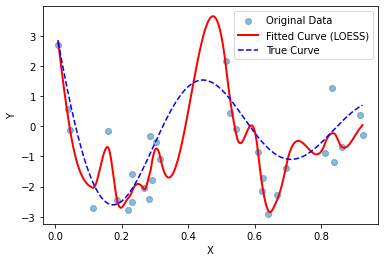

In [37]:
# Load the dataset
data = pd.read_csv("Coding3_Data.csv")
x = data['x'].values
y = data['y'].values

# Define span values
spans = np.linspace(0.20, 0.90, 15)

# Calculate CV and GCV
cv_errors, gcv_errors = calculate_cv_gcv(x, y, spans)

# Find the optimal span
optimal_span_cv = spans[np.argmin(cv_errors)]
optimal_span_gcv = spans[np.argmin(gcv_errors)]

print(f"Optimal span (CV): {optimal_span_cv}")
print(f"Optimal span (GCV): {optimal_span_gcv}")

# Fit LOESS model with optimal span
optimal_span = optimal_span_cv  # Both methods recommend the same span
loess_model = loess(x, y, span=optimal_span)
loess_model.fit()

# Create a finer grid for smoother curve
grid_x = np.linspace(x.min(), x.max(), 500)
y_pred = loess_model.predict(grid_x, stderror=True).values

# Plot the results
plt.scatter(x, y, label='Original Data', alpha=0.5)
plt.plot(grid_x, y_pred, color='red', label='Fitted Curve (LOESS)', linewidth=2)
plt.plot(grid_x, np.sin(12 * (grid_x + 0.2)) / (grid_x + 0.2), color='blue', label='True Curve', linestyle='--')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()